- 레이블링된 데이터가 전혀 없거나 매우 적은 경우, 잘 맞는 방법 몇가지
    - 제로샷 학습(zero-shot learning) 또는 퓨샷 학습(few-shot learning)
 

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree" width="700px"/>

- 레이블링 된 데이터가 충분치 않을 때 모델 성능 향상을 위해 사용하는 여러가지 방법 및 과정
    - 레이블링 된 데이터가 있는가
        - 전혀 없다면 제로샷 학습
    - 레이블링 된 데이터가 얼마나 있는가
        - 레이블링 된 데이트의 양에 따라, 충분히 많다면 미세 튜닝을 한다
    - 레이블링되지 않는 데이터가 있는가
        - 레이블링 된 데이터가 조금 있고, 안된 데이터가 많다면
            - 레이블링 되지 않은 데이터로 도메인에서 언어 모델을 미세튜닝 하는 방법
            - 비지도 데이터 증식(unsupervised data augmentation, UDA)
            - 불확실성 인지 자기 훈련(uncertainty-aware self-training, UST)
        - 레이블링 안된 데이터가 전혀 없다면 데이터 레이블링해 늘릴수 없다
            - 퓨샷 학습
            - 임베딩 룩업 : 사전 훈련된 언어 모델의 임베딩을 사용해 취근접 이웃 검색으로 룩업 수행

- 사용 데이터
    - [트렌스포머스의 깃허브 이슈](https://github.com/huggingface/transformers/issues) 사용

# 깃허브 이슈 태거 만들기

<img alt="issue-example" caption="A typical GitHub issue on the Transformers repository" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_issue-example-v2.png?raw=1" id="issue-example"/>

- 제목, 설명, 이슈의 특징을 나타내는 일련의 태크 또는 레이블이 있음
    - 지도 학습용으로 적절 : 이슈의 제목과 설명이 주어지면 한 개 이상의 레이블을 예측
    - 다중 레이블 텍스트 분류 : 이슈에 여러 레이블 할당 가능

## 데이터 다운로드하기
- 저장소의 이슈를 모두 다운로드 하는 방법
    - 깃허브 [REST API](https://docs.github.com/en/rest?apiVersion=2022-11-28) 에 있는 [issue endpoint](https://docs.github.com/en/rest/issues?apiVersion=2022-11-28#list-repository-issues)를 반복 호출 해야
    - JSON 객체의 리스트 반환
        - 이슈 상태(오픈, 클로즈), 이슈 생성자, 제목, 본문, 레이블, 관련 링크
    - 받는데 오래 걸리니 이미 받아 놓은 json 파일 사용

### 이슈 다운로드 코드

- 직접 이슈를 다운로드하고 싶다면 파이썬에서 HTTP 요청을 처리하는 대표적인 라이브러리인 _Requests_ 를 사용해 Issues 엔드포인트를 호출할 수 있습니다. 다음은 허깅페이스 트랜스포머스 저장소의 이슈를 다운로드하는 함수입니다.

In [92]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,
                 rate_limit=5_000):
    batch = []
    all_issues = []
    per_page = 100     # 페이지마다 반환되는 이슈 개수
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        # 오픈 이슈와 클로즈 이슈를 모두 가져오기 위해 state=all로 쿼리합니다.
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = []   # 다음 번 요청을 위해 비웁니다.
            print(f"깃허브 요청 한도에 도달했습니다. 한 시간 동안 중지합니다...")
            time.sleep(60 * 60 + 1)

    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

In [93]:
# fetch_issues()

## 데이터 준비하기

In [94]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"데이터프레임 크기: {df_issues.shape}")

데이터프레임 크기: (9930, 26)


- 10,000개의 이슈
- 데이터 확인해 보기

In [95]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


- 이중 labels에 주목 : 각 행마다 레이블에 대한 메타데이터로 구성된 JSON 객체 리스트 포함

In [96]:
df_issues.loc[2, 'labels']

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

- labels 객체의 name 필드에만 관심이 있음
- name으로 labels 열을 덮어 쓴다

In [97]:
df_issues['labels'] = (
    df_issues['labels'].apply(lambda x : [meta['name'] for meta in x])
)
df_issues['labels'].head()

0             []
1             []
2    [DeepSpeed]
3             []
4             []
Name: labels, dtype: object

- 이슈에 할당된 레이블 갯수

In [98]:
df_issues['labels'].apply(lambda x:len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


- 대부분의 이슈는 레이블이 없거나 하나
- 데이터셋에서 가장 많이 등장하는 상위 8개의 레이블 확인

In [99]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"레이블 개수: {len(df_counts)}")
# 상위 8개 레이블을 출력합니다.
df_counts.to_frame().head(8).T

레이블 개수: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


- 고유한 레이블이 65개
- wontfix와 model card가 가장 자주 등장

**explode() 이해하기**

`pandas`의 `explode()` 함수는 하나의 셀에 리스트나 배열과 같은 iterable 형태로 저장된 데이터를 행 단위로 확장하여 데이터프레임을 만드는 함수입니다. 이를 이해하기 위해 간단한 예제를 만들어보겠습니다.

먼저, 다음과 같은 데이터프레임을 생성합니다:

```python
import pandas as pd

data = {
    'A': ['a', 'b', 'c'],
    'B': [[1, 2], [3, 4], [5, 6]]
}

df = pd.DataFrame(data)
print(df)
```

이렇게 하면 다음과 같은 데이터프레임이 생성됩니다:

```
   A       B
0  a  [1, 2]
1  b  [3, 4]
2  c  [5, 6]
```

여기서 'B' 열의 각 셀에는 리스트가 포함되어 있습니다. 이제 `explode()` 함수를 사용하여 'B' 열의 리스트를 행 단위로 확장해보겠습니다:

```python
exploded_df = df.explode('B')
print(exploded_df)
```

이렇게 하면 다음과 같은 데이터프레임이 생성됩니다:

```
   A  B
0  a  1
0  a  2
1  b  3
1  b  4
2  c  5
2  c  6
```

여기서 볼 수 있듯이, `explode()` 함수는 'B' 열의 각 셀에 있는 리스트를 행 단위로 확장하여 새로운 행을 생성합니다. 이것이 `explode()` 함수의 기본적인 작동 방식입니다.

- labels 를 읽기 편한 tag로 수정 하고, 사용할 것만 남긴다

In [100]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

In [101]:
def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues['labels'] = df_issues['labels'].apply(filter_labels)
all_labels = list(label_map.values())

- 새로운 레이블의 분포

In [102]:
df_issues['labels'].explode().value_counts().to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [103]:
df_issues['split'] = 'unlabeled'
mask = df_issues['labels'].apply(lambda x : len(x)) > 0
df_issues.loc[mask, 'split'] = 'labeled'
df_issues['split'].value_counts().to_frame().T

split,unlabeled,labeled
count,9489,441


- 샘플 하나 확인

In [104]:
for column in ['title', 'body', 'labels']:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



- title 정보가 분류기에 유용, body 필드와 병합

In [105]:
df_issues['text'] = (
    df_issues.apply(lambda x:x['title'] + '\n\n' + x['body'] , axis=1)
)

- 중복된 이슈 제거

In [106]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset='text')
print(f"삭제된 중복 이슈: {(len_before-len(df_issues))/len_before:.2%}")

삭제된 중복 이슈: 1.88%


- 모델의 입력 한계에 따른 너무 많은 정보 손실 가능성 확인

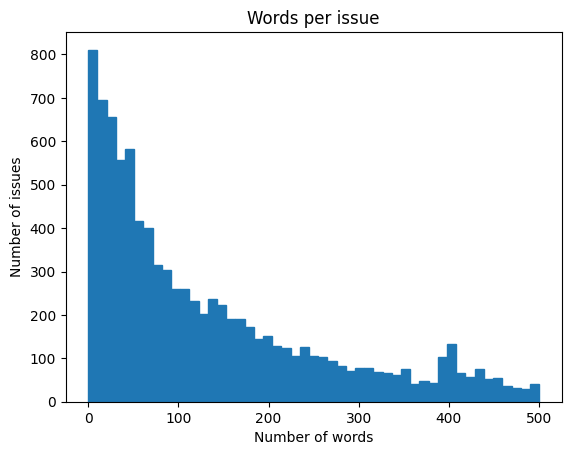

In [107]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues['text'].str.split().apply(len).
 hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor='C0'))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

- 대부분의 모델의 입력 크기는 512 토큰
- 이를 넘어서는 데이터가 영향을 미칠 것으로는 보이지 않음

## 훈련 세트 만들기
- 다중 레이블링 문제는 훈련 세트와 검증 세트를 만드는 것은 다소 까다로움
    - 모든 레이블에 대해 균형 잡힌 비율을 보장하지 않기 때문
    - scikit-multilearn 라이브러리가 도움이 됨
- pytorch와 tokenization과 같은 레이블을 모델이 처리 가능한 포멧으로 변환
    - 사이킷런의 MultiLabelBinarizer 클래스 사용
    - 레이블 이름의 리스트를 받고 레이블에 해당하는 위치는 1, 나머지는 0으로 벡터 생성
    - 레이블 이름을 ID로 매핑하기 위해 all_labels 리스트에 MultiLabelBinarizer 클래스 적용

In [108]:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [109]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

- iterative_train_test_split() 함수로 label별로 균형 잡힌 훈련/테스트 데이터 분리
    - 이 함수는 2차원 특성 행렬을 기대 함, 분할 전 인덱스 배열에 차원 추가

In [110]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

- 지도학습 데이터셋과 비지도학습 데이터셋으로 분리
- balanced_split() 함수를 사용 지도 학습 데이터 셋을 학습, 검증, 테스트 세트로 균형 있게 분리

In [111]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

- 실제 데이터를 토큰화하고 Trainer와 통합 하기 위한 모든 분할을 담은 DatasetDict 객체 생성

In [112]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

## 훈련 슬라이스 만들기
- 희소하게 레이블링 된 데이터와 다중 레이블 분류
- 적은 양의 레이블링 된 데이터에서 얼마나 좋은 성능을 낼 수 있는지 확인을 위해 샘플 개수가 더 적은 훈련 데이터의 슬라이스 생성
- 샘플 개수에 대한 성능을 그래프로 그려 여러 방법 분석

In [113]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플을 분할합니다
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

- 원하는 크기에 근사하게 샘플을 나눈다
- 그래를 그릴때 x축에 해당

In [114]:
print("목표 분할 크기:")
print(train_samples)
print("실제 분할 크기:")
print([len(x) for x in train_slices])

목표 분할 크기:
[8, 16, 32, 64, 128, 223]
실제 분할 크기:
[10, 19, 36, 68, 134, 223]


# 나이브 베이즈 모델 만들기
- 텍스트 분류에서 좋은 베이스라인 모델로 사용 됨
- 간단하고 속도가 빠르며 입력의 변동에 매우 안정적
- 사이킷런의 나이브 베이즈 모델은 다중 분류 지원하지 않음
- scilit-multilearn 라이브러리로 OvR(one-versus-rest) 문제로 바꿔 작업
    - L개의 레이블을 위해 L개의 이진 분류기를 훈련
- MultiLabelBinarizer 객체를 사용해 새로운 훈련 세트에 label_ids 생성

In [115]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [116]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 9303
    })
})

In [117]:
ds['train']['label_ids']

[[0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0,

- 분류기 성능 평가를 위해 f1 score(macro, micro) 사용
- f1 score의 구체적인 계산식은 다음과 같습니다.

1. Macro F1 Score:
매크로 F1 점수는 모든 클래스의 F1 점수를 평균화한 값입니다. 클래스별로 F1 점수를 계산하고 이를 평균합니다. 이때 각 클래스의 F1 점수를 동일한 가중치로 고려합니다.

$ \text{Macro F1 Score} = \frac{1}{N} \sum_{i=1}^{N} F1_i \$

여기서 $N $은 클래스의 수이고, $F1_i$는 각 클래스 $ i $의 F1 점수입니다.

2. Micro F1 Score:
마이크로 F1 점수는 모든 클래스의 정밀도 및 재현율을 사용하여 F1 점수를 계산하고, 이들의 평균을 구합니다. 모든 클래스에 대한 정밀도와 재현율의 가중 평균을 계산합니다.

$ \text{Micro F1 Score} = \frac{2 \times \text{TP}}{2 \times \text{TP} + \text{FP} + \text{FN}} $

여기서 TP는 True Positives, FP는 False Positives, FN은 False Negatives입니다.

매크로 F1 점수와 마이크로 F1 점수는 다음과 같은 차이가 있습니다:
- 매크로 F1 점수는 각 클래스의 F1 점수를 동일한 비중으로 고려합니다.
- 마이크로 F1 점수는 모든 클래스의 샘플 수를 고려하여 계산됩니다. 클래스별 샘플 수가 고려되므로 클래스 불균형이 있는 데이터셋에서 더 적절한 평가 지표가 될 수 있습니다.

- 각 모델을 다른 훈련 분할에서 평가, 이를 담기 위한 리스트 생성

In [118]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [119]:
macro_scores

defaultdict(list, {})

- 훈련 세트 크기에 따른 모델 훈련, 평가

In [120]:
train_slices

[array([ 0,  2,  9, 11, 18, 19, 45, 52, 54, 92]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,  27,  30,  31,  33,  35,  36,  44,  57,  64,  69,
         73,  74,  78,  80,  90,  91,  99, 105, 123, 136, 141, 152, 180,
        184, 190, 197]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,

In [121]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터를 준비합니다
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩합니다
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 모델을 만들고 훈련합니다!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측을 생성하고 평가합니다
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # 평가 결과를 저장합니다
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [122]:
clf_report

{'documentation': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 7.0},
 'examples': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 6.0},
 'model training': {'precision': 1.0,
  'recall': 0.0625,
  'f1-score': 0.11764705882352941,
  'support': 16.0},
 'new model': {'precision': 0.8461538461538461,
  'recall': 0.9166666666666666,
  'f1-score': 0.88,
  'support': 24.0},
 'pipeline': {'precision': 0.5,
  'recall': 0.18181818181818182,
  'f1-score': 0.26666666666666666,
  'support': 11.0},
 'pytorch': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 10.0},
 'tensorflow or tf': {'precision': 0.5714285714285714,
  'recall': 0.36363636363636365,
  'f1-score': 0.4444444444444444,
  'support': 11.0},
 'tokenization': {'precision': 0.625,
  'recall': 0.9615384615384616,
  'f1-score': 0.7575757575757576,
  'support': 26.0},
 'usage': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0},
 'micro avg': {'precision': 0.683544

- 실험 결과 그래프로 표시

In [123]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

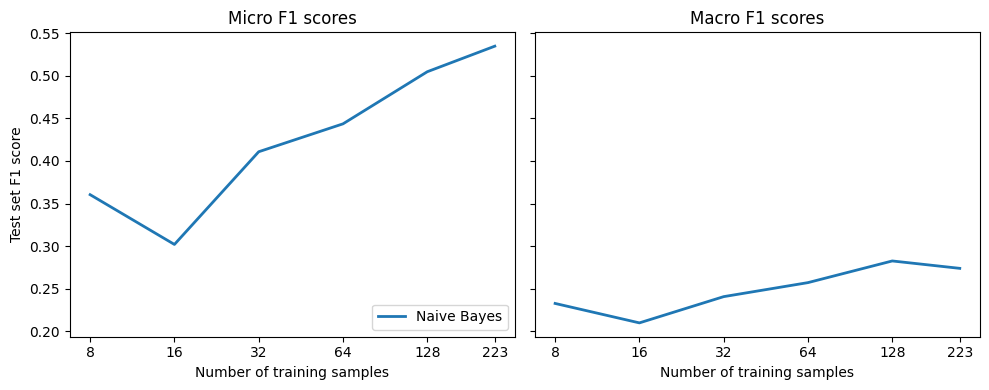

In [124]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

- 샘플수 증가에 따라, 매크로, 마이크로 f1 점수 모두 향상하는 추세
    - 샘플수가 너무 작으면 슬라이스 마다 클래스 분포가 달라져 결과에 잡음 발생

# 레이블이 없는 데이터 다루기

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree" width="700px"/>

- 레이블이 전혀 없는 상황에 적합한 제로샷 분류(zero-shot classification)
- 작업별 말뭉치에서 추가로 미세 튜닝 없이 사전 훈련된 모델을 사용하는 것이 목표
- BERT 같은 언어모델은 수천권의 책과 위키피디아 대규모 덤프에서 마스킹된 토큰을 예측 하도록 훈련 되었다
- 이를 위해선 문맥에 있는 주제를 인식 해야 한다
- 예제
    - 자동차와 동물을 좋아하는 두 아이가 있다
    - 이미 개봉된 영화를 모두 보았을 때, 새 영화의 주제를 알려주는 문제
    - BERT의 fill-mask 사용

In [125]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- 약간의 영화 설명을 작성 후, 마스킹된 단어를 위한 프롬프트 작성
    - 이 프롬프트는 모델이 분류하도록 안내하는 역할
- fill-mask 파리프라인은 마스킹된 위치에 놓기에 가장 가능성이 높은 토큰 반환

In [126]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:	0.103%
토큰 lions:	0.066%
토큰 birds:	0.025%
토큰 love:	0.015%
토큰 hunting:	0.013%


- 가장 가능성이 높은 토큰이 아니라, 주어진 토큰에 대한 확률 출력 하도록 수정

In [127]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:	0.103%
토큰 cars:	0.001%


- 자동차 관련 테스트

In [128]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 cars:	0.139%
토큰 animals:	0.006%


- 좀 더 비슷한 작업에서 훌련된 모델을 사용하는 것이 더 좋을 때도 있음
    - 텍스트 함의(text entailment)
    - 모델이 두개의 텍스트 구정이 서로 연결되는지 아니며 모순되는 판단
    - 모델은 일반적으로 MNLI(multi-genre NLI)말뭉치나 XNLI(Cross-lingual NLI) 말뭉치 같은 데이터에서 모순 여부 학습

In [129]:
from transformers import pipeline

# CPU에서 실행하려면 device=0을 삭제하세요.
pipe = pipeline("zero-shot-classification", device=0)

- multi_label=True : 모든 레벨에 대한 점수 출력

In [130]:
sample = ds["train"][0]
print(f"레이블: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\n예측:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

레이블: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

예측:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


- 정답(new model) 뿐만 아니라 다른 label도 높은 점수
- 이 모델이 학습한 데이터와 우리가 다루는 데이터가 상이하기 때문
- 위 내용을 전체 데이터에 적용하도록 함수화

In [131]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


- 샘플마다 어떤 레이블을 할당할 것인가의 두가지 선택지
    - 임계값을 정의하고, 이 임계값을 초과한 모든 레이블 선택
    - 점수가 높은 순으로 상위 k개 레이블 선택

In [132]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("`threshold` 또는 `topk`로 지정해야 합니다.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

- 분류 결과를 리포팅 하는 함수

In [133]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

- topk 방법의 결과

In [134]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

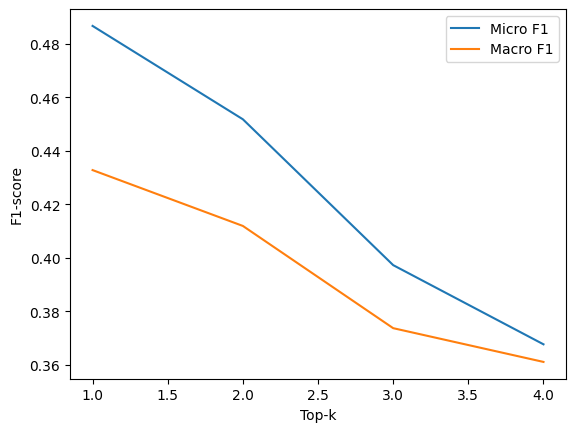

In [135]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

- k가 작을 수록(샘플당 점수가 가장 높은 레이블만 고르는) 방식이 좋다
- 임계값 방식과 비교

In [136]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

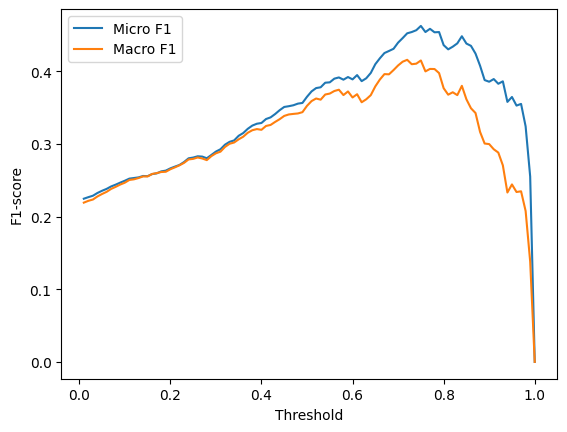

In [137]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [138]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'최상의 임곗값 (마이크로): {best_t}, F1-점수 {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'최상의 임곗값 (마크로): {best_t}, F1-점수 {best_macro:.2f}.')

최상의 임곗값 (마이크로): 0.75, F1-점수 0.46.
최상의 임곗값 (마크로): 0.72, F1-점수 0.42.


- top-1 보다는 다소 떨어지지만, 임계값이 0.8 부근이 최적의 값으로 보임
- top-1로 테스트 세트에서 제로샷 분류와 나이브 베이즈 비교

In [139]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

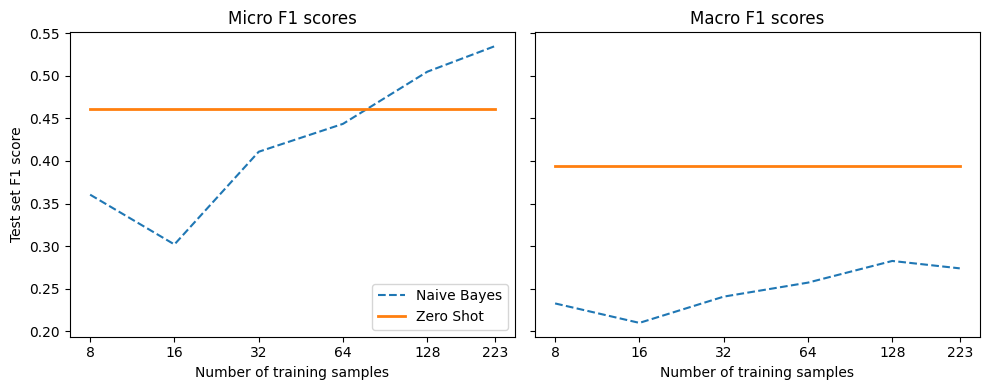

In [140]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

- 실험 결과
    - 레이블링 된 샘플이 50개 보다 작다면, 제로샷 파이프라인이 기준 모델 성능을 추춸
    - 샘플이 50개 이상이라도, 마크로 f1 점수를 고러하면 제로샷 파이프라인이 우월 
        - 마이크로 f1 점수, 기존 모델이 빈도가 높은 클레스에서 잘 작동, 제로샷이 학습 샢플이 불필요 하기에 더 우수
- 주의
    - 실전에서는 레이블이 없는 상황이라도 검증용 데이터는 모델 하이퍼파라미터 조정을 위해 남겨 두는 것이 좋다

# 레이블이 적은 데이터 다루기

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree" width="700px"/>

- 극소량의, 고객이나 다른 팀에서 얻은 샘플 몇 개의 레이블 데이터가 있을 때
- 제로샷 방식의 평가를 위해 사용 가능

## 데이터 증식
- 기존 샘플에서 새 훈련 샘플을 생성하는 데이터 증식
- 간단하지만 효과적으로 작은 데이터셋에서 텍스트 분류기의 성능 향상 가능
- 비전 분야에서는 일반적
    - 데이터의 의미를 바꾸지 않고 이미지를 랜덤하게 변형
- 텍스트는 의미가 달라져 증식이 까다롭다
- 사용되는 증식 방법
    - 역 번역 : 기계 번역으로 다른 언어로 번역 후 원래 언어로 번역, M2M100과 같은 기계 번역 모델 사용
    - 토근 섞기 : 동의어 교체, 단어 추가, 교환, 삭제, NlpAug의 ContextaulWOrdEmbdsAug 로 동의어 교체

In [141]:
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/restful3/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/restful3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/restful3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [142]:
set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de',
    to_model_name='facebook/wmt19-de-en'
)
for k,v in augs.items():
    print(f"원본 텍스트: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: ['Even if you vote down me Megatron, others will turn out to defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: ['even if you defeat me megatron, others will rise to forever defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: ['Even if you defeat Megatron me, others to will rise defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: ['Even if me Megatron, will rise to tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
bt_en_de: ['乱natürŮ ཅnatürαMärchen Bachel画Bachel画Bachel画Bachelprogramme ਼ Bachel画Bachel画暁 Bachel画Bachel画Bachel画Bachel画Bachel画Bachel画家家家家家家家家家家家家家家家家家家家家家家家家家家家家家家家家家家家家家 ＊ 幹幹幹幹 geschossen Tiefdigungen Tiefdigungen Tiefdigungen Tiefdigungen Tiefdig

In [143]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cpu", action="substitute")

text = "Transformers are the most popular toys"
print(f"원본 텍스트: {text}")
print(f"증식된 텍스트: {aug.augment(text)}")

원본 텍스트: Transformers are the most popular toys
증식된 텍스트: ['transformers — the most coveted toys']


- 증강 결과
- 함수화

In [144]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

- augment_text() 함수를 전달 할 때 transformations_per_example 옵션으로 생성 할 샘플 수 조정 가능
- 훈련 슬라이스를 선택 후 코드 한줄만 추가하면 나이브 베이즈로 훈련 가능

In [145]:
for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터를 준비합니다
    ds_train_sample = ds["train"].select(train_slice)
    # 증식 결과를 펼쳐서 레이블에 정렬합니다!
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩합니다
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 모델을 만들고 훈련합니다!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측을 생성하고 평가합니다
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # 평가 결과를 저장합니다
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

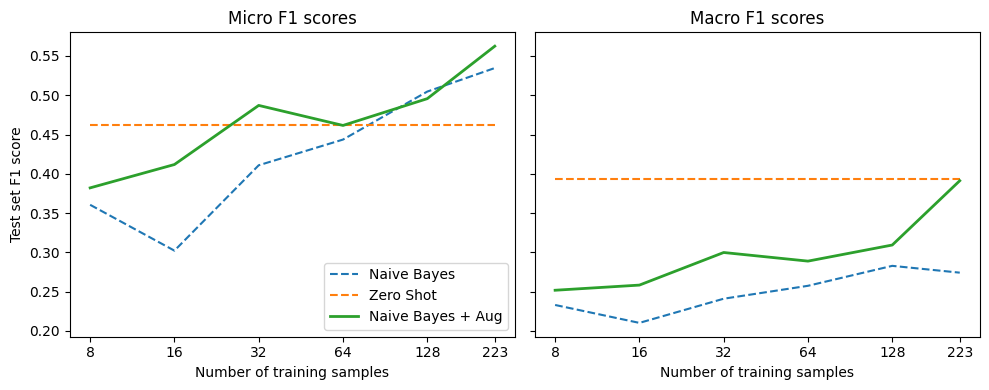

In [146]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

- 데이터 증식으로 베이즈 분류기의 f1 포인트가 상승
- 170개 훈련 샘플에서는 제로샷도 추월

## 임베딩을 룩업 테이블로 사용하기

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree" width="700px"/>

- 대규모 언어모델은 제한된 데이터로 문제를 해결하는 능력이 뛰어남
- 대규모 언어 모델을 사용, 의미 검색 엔진(semantic search engine)을 개발, 비슷한 문서나 코멘트를 찾고, 텍스트를 분류 하는 작업 가능
    - 언어 모델을 사용 레이블링 된 전체 텍스트를 임베딩
    - 저장된 임베딩의 최근접 이웃 검색을 수행
    - 최근접 이웃의 레이블을 수집해 예측을 만듦

<img alt="nearest-neighbours" caption="An illustration of nearest neighbor embedding lookup" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_nearest-neighbours.png?raw=1" id="nearest-neighbours" width="400px"/>

- GPT-2 를 사용(3는 유료니까)
- GPT-2는 토큰마다 임베딩 벡터를 반환
- 따라서 문장 전체의 벡터를 각 토큰의 벡터로 부터 생성 해야 함
- 풀링 기법 사용 : 
    - 평균 풀링 : 각 토큰의 벡터를, 패딩 토큰을 제외 하고 평균

In [147]:
import joblib

embedding_results = joblib.load('./nlp-with-transformers-main/09_results_of_faiss.gz')
macro_scores["Embedding"] = embedding_results["macro"]["Embedding"]
micro_scores["Embedding"] = embedding_results["micro"]["Embedding"]

- 각 데이터 분할에 대한 임베딩 구함

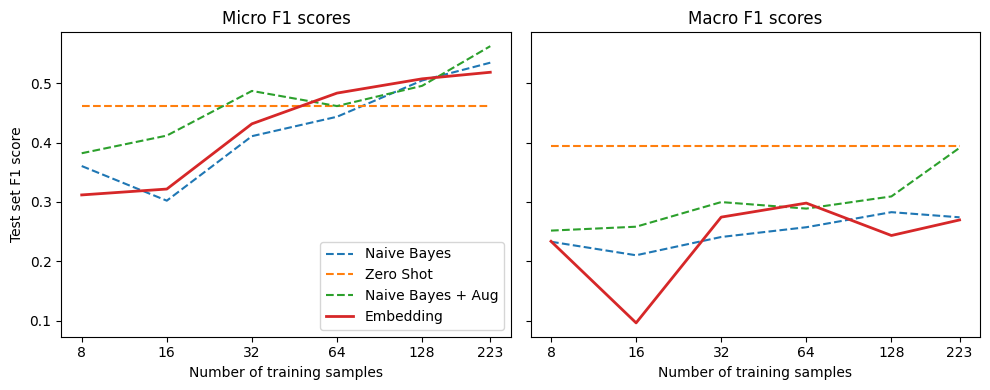

In [148]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

- 임베딩 룩업은 학습 가능한 파라미터 k와 m이 있어 다른 방법 대비 경쟁력이 있다
- 하지만 마크로에서는 낮은 결과
- 도메인 별로 다른 결과가 있을 수 있다

### FAISS를 사용한 효율적인 유사도 검색

<img alt="faiss-index" caption="The structure of a FAISS index: the gray points represent data points added to the index, the bold black points are the cluster centers found via k-means clustering, and the colored areas represent the regions belonging to a cluster center" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_faiss-index.png?raw=1" id="faiss-index" width=600/>

- FAISS 라이브러리의 작동 방식과 ML 에서 이 라이브러리가 강한 이유
- 문서를 벡터화 하면, 새로운 쿼리와 절대 정확하게 일치 하지 않는다. 따라서 유사도를 반영해야 한다.
- 데이터베이스에서 쿼리 벡터와 가장 비슷한 벡터를 찾고 싶다면 모든 벡터와 모두 비교 해야 한다.
- 데이터베이스의 벡터가 많으면 문제가 된다.
- FAISS는, 데이터셋을 분할 하여 이 문제를 해결 하였다.
- k-평균 클러스터링 을 적용, 유사도에 따라 임베딩을 그룹화 하고, 각 그룹에 센트로이드 벡터를 얻는다
- 쿼리와 비슷한 센트로이드를 우선 찾고, 그 안에서 k개를 찾는 구조
- 이 외에도, GPU를 활용하거나, 벡터를 양자화 하는 방법 등이 사용됨.

## 기본 트랜스포머 미세 튜닝하기

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree" width="700px"/>

- 사전 훈련된 토크나이저로 데이터셋 토큰화
- 학습에 필요 없는 컬럼 삭제

In [149]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
    
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

- 손실 함수는 이산적인 레이블 대신 클래스 확률도 사용 가능하기 때문에 실수 타입의 레이블로 수정

In [150]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

- load_best_model_at_end : 데이터 크기가 작아 과적합을 막기 위해 f1스코어를 기반으로 최선의 모델 찾는다

In [151]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0,
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

- 시그모이드 함수로 예측을 정규화 하고
- 간단한 임곗값(0.5)으로 이를 이진화

In [152]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

- 훈련 세트 슬라이스마다 분류기 훈련
- 훈련 루프 끝에서 최상위 모델 로드
- 테스트 결과 저장

In [153]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [154]:
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.6541, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6113460659980774, 'eval_micro f1': 0.22568093385214008, 'eval_macro f1': 0.06701940035273368, 'eval_runtime': 0.4096, 'eval_samples_per_second': 258.807, 'eval_steps_per_second': 9.766, 'epoch': 1.0}
{'loss': 0.584, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5671236515045166, 'eval_micro f1': 0.2119815668202765, 'eval_macro f1': 0.04224058769513315, 'eval_runtime': 0.406, 'eval_samples_per_second': 261.109, 'eval_steps_per_second': 9.853, 'epoch': 2.0}
{'loss': 0.5436, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5160601735115051, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4064, 'eval_samples_per_second': 260.835, 'eval_steps_per_second': 9.843, 'epoch': 3.0}
{'loss': 0.5023, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.4956599473953247, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4055, 'eval_samples_per_second': 261.422, 'eval_steps_per_second': 9.86

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.6065, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5522905588150024, 'eval_micro f1': 0.05309734513274336, 'eval_macro f1': 0.011904761904761904, 'eval_runtime': 0.408, 'eval_samples_per_second': 259.8, 'eval_steps_per_second': 9.804, 'epoch': 1.0}
{'loss': 0.5123, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.47928866744041443, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.408, 'eval_samples_per_second': 259.831, 'eval_steps_per_second': 9.805, 'epoch': 2.0}
{'loss': 0.4542, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.43922388553619385, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4075, 'eval_samples_per_second': 260.104, 'eval_steps_per_second': 9.815, 'epoch': 3.0}
{'loss': 0.4076, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.40907806158065796, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4082, 'eval_samples_per_second': 259.68, 'eval_steps_per_second': 9.799, 'epoch': 4.0}
{'loss': 0.37

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.5809, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.49861636757850647, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4078, 'eval_samples_per_second': 259.9, 'eval_steps_per_second': 9.808, 'epoch': 1.0}
{'loss': 0.4479, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4215277135372162, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4069, 'eval_samples_per_second': 260.505, 'eval_steps_per_second': 9.83, 'epoch': 2.0}
{'loss': 0.3921, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.38643935322761536, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4076, 'eval_samples_per_second': 260.059, 'eval_steps_per_second': 9.814, 'epoch': 3.0}
{'loss': 0.3509, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3678700029850006, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4075, 'eval_samples_per_second': 260.145, 'eval_steps_per_second': 9.817, 'epoch': 4.0}
{'loss': 0.3228, 'learning_rate': 3e-05, 'epo

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.5376, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.4288795292377472, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4077, 'eval_samples_per_second': 260.009, 'eval_steps_per_second': 9.812, 'epoch': 1.0}
{'loss': 0.3949, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.37521758675575256, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4085, 'eval_samples_per_second': 259.497, 'eval_steps_per_second': 9.792, 'epoch': 2.0}
{'loss': 0.3541, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.35882216691970825, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4097, 'eval_samples_per_second': 258.726, 'eval_steps_per_second': 9.763, 'epoch': 3.0}
{'loss': 0.3416, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.34586697816848755, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.41, 'eval_samples_per_second': 258.52, 'eval_steps_per_second': 9.755, 'epoch': 4.0}
{'loss': 0.3231, 'learning_rate': 3e-05, 'ep

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.4588, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.37415334582328796, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4089, 'eval_samples_per_second': 259.249, 'eval_steps_per_second': 9.783, 'epoch': 1.0}
{'loss': 0.3487, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.34442153573036194, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.409, 'eval_samples_per_second': 259.157, 'eval_steps_per_second': 9.78, 'epoch': 2.0}
{'loss': 0.3175, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.32175320386886597, 'eval_micro f1': 0.22058823529411764, 'eval_macro f1': 0.08333333333333333, 'eval_runtime': 0.4099, 'eval_samples_per_second': 258.582, 'eval_steps_per_second': 9.758, 'epoch': 3.0}
{'loss': 0.2822, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.28491953015327454, 'eval_micro f1': 0.4230769230769231, 'eval_macro f1': 0.16707906209496878, 'eval_runtime': 0.4089, 'eval_samples_per_second': 259.208, 'eval_steps_per_second': 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

{'loss': 0.426, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.35793909430503845, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4096, 'eval_samples_per_second': 258.783, 'eval_steps_per_second': 9.765, 'epoch': 1.0}
{'loss': 0.3308, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3201952278614044, 'eval_micro f1': 0.13953488372093023, 'eval_macro f1': 0.0606060606060606, 'eval_runtime': 0.4107, 'eval_samples_per_second': 258.094, 'eval_steps_per_second': 9.739, 'epoch': 2.0}
{'loss': 0.2887, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.28052327036857605, 'eval_micro f1': 0.4230769230769231, 'eval_macro f1': 0.16790123456790124, 'eval_runtime': 0.4113, 'eval_samples_per_second': 257.726, 'eval_steps_per_second': 9.726, 'epoch': 3.0}
{'loss': 0.2459, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.25171801447868347, 'eval_micro f1': 0.5263157894736842, 'eval_macro f1': 0.2707277452891488, 'eval_runtime': 0.412, 'eval_samples_per_second': 257.30

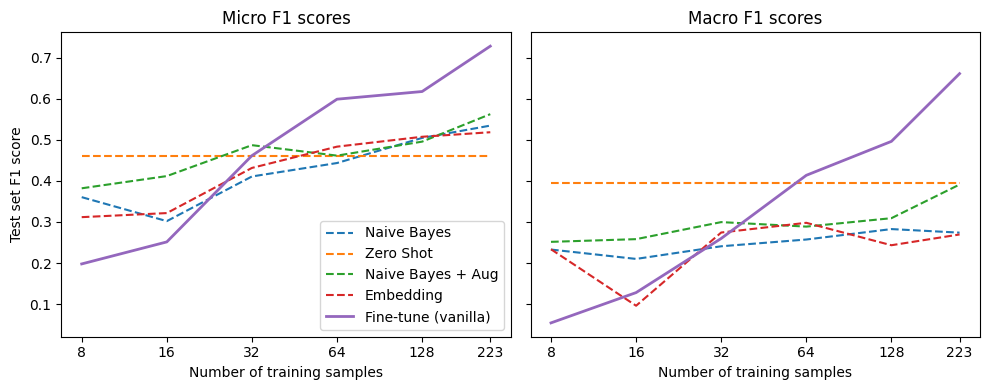

In [155]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

- 기본적인 BERT 모델을 간단히 미세 튜닝해 64개 샘플에서 경쟁력 있는 모델 얻음
- (샘플이 적으면) 약간 불규칙한 행동을 보인다. 

## 프롬프트를 사용한 인-컨텍스트 학습과 퓨-샷 학습
- BERT나 GPT-2사용시 프롬프트를 사용해 모델의 토큰 예측을 파싱
- 작업에 특화된 헤드 추가, 모델 파라미터를 작업에 맞게 튜닝하는 전통적인 방법이 아니다.
- 훈련 데이터가 전혀 필요 없고, 레이블링 된 데이터를 사용 할 수 없는 단점

```python
prompt = """\
Translate English to French:
thanks =>
"""
```

- 위와 같이 영어를 프랑스어로 번역하는 작업
- GPT-3는 위와 같은 프롬프트가 있다면, 모델의 작업 성능이 더 뛰어나다
- 모델이 클 수록 인-컨텍스트로 인한 성능이 더 향상 된다

# 레이블링되지 않은 데이터 활용하기

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree" width="700px"/>

- **전이 학습의 개념**: 전이 학습은 사전 훈련된 모델의 지식을 새로운 작업에 전이하여 성능을 개선하는 학습 방법입니다. 기존에 사용된 데이터셋과 유사한 도메인에서 사전 훈련된 모델은 후속 작업에서 더 나은 성능을 발휘할 수 있습니다.
- **BERT를 예로 든 전이 학습**: BERT는 BookCorpus와 영어 위키피디아와 같은 대규모 텍스트 데이터에서 사전 훈련됩니다. 하지만 모든 도메인에 적합한 데이터셋을 사전 훈련하기는 어렵고 비용이 많이 들 수 있습니다.
- **도메인 적응(Domain Adaptation)**: 도메인 적응은 사전 훈련된 언어 모델을 특정 도메인에 맞게 조정하는 방법입니다. 이를 위해 레이블링된 데이터가 필요하지 않으며, 도메인의 특성을 반영하기 위해 모델을 새로운 데이터로 계속 훈련합니다.
- **도메인 적응의 장점**: 도메인 적응은 레이블링된 데이터보다 레이블링되지 않은 데이터가 풍부한 경우에 유용합니다. 또한 도메인 적응된 모델은 여러 작업에서 재사용할 수 있어 효율적입니다.
    - **예시**: 이메일 분류기를 도메인 적응하여 다른 분류 작업에 활용할 수 있습니다. 이는 후속 작업에 무관한 도메인 적응 방식의 장점을 보여줍니다.

## 언어 모델 미세 튜닝하기

- 사전 훈련된 모델을 레이블링이 없는 데이터로 미세튜닝 하기
- **토큰화(Tokenization)**: 텍스트를 토큰화하는 과정에서 특수 토큰인 [CLS]와 [SEP] 같은 토큰들을 추가합니다. 이러한 특수 토큰들은 분류 작업이나 다음 문장 예측과 같은 추가적인 작업을 위해 사용됩니다. 마스크드 언어 모델링에서는 특수 토큰들에 대한 예측을 수행하지 않으며, 이러한 특수 토큰들은 손실을 계산할 때 마스킹됩니다. `return_special_tokens_mask=True`로 설정하면 토큰화 과정에서 마스크를 얻을 수 있습니다.

In [156]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

- **마스크드 언어 모델링**: 입력 시퀀스의 일부 토큰을 마스킹하고, 출력에서는 해당 마스킹된 토큰을 예측하는 방식의 언어 모델링입니다. 랜덤한 토큰을 마스킹하고 시퀀스에 대한 레이블을 생성하는 함수를 작성해야 하며, 이를 통해 데이터셋의 크기는 두 배가 됩니다. 또한 데이터 셋에는 입력 시퀀스와 해당 마스킹된 토큰을 함께 저장해야 합니다.

- **데이터 콜레이터(Data Collator)**: 데이터 콜레이터는 데이터셋과 모델 호출 사이를 연결하는 함수입니다. 데이터 콜레이터를 사용하면 모델에 입력될 데이터를 준비할 수 있습니다. 데이터 콜레이터를 사용하는 방식은 데이터셋에서 샘플링한 후 해당 샘플에 대해 마스킹과 레이블 생성을 동적으로 수행합니다. 이를 위해 `DatacollatorForLanguageModeling`을 사용하며, 모델의 토크나이저와 마스킹할 토큰 비율을 초기화하여 동작시킵니다. 이 콜레이터는 BERT 논문에서 제안된 15%의 토큰을 마스킹하는 방식을 따릅니다.

In [157]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

- 데이터 콜레이터 실행

In [158]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
original_input_ids = inputs["input_ids"][0]
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


- 느낌표에 해당하는 토큰이 마스킹 토큰으로 바뀜
- 데이터 콜레이터가 레이블 배열을 반환 : 원본은 -100, 마스킹된 토큰은 토큰 ID
    - -100은 손실 계산시 무시 됨

In [159]:
data_collator.return_tensors = "pt"

- 마스크드 언어 모델 미세 튜닝

In [160]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=False, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/restful3/anaconda3/envs/trading/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 2.0997, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.6987422704696655, 'eval_runtime': 1.1592, 'eval_samples_per_second': 192.367, 'eval_steps_per_second': 24.154, 'epoch': 1.0}
{'loss': 1.6376, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.4328354597091675, 'eval_runtime': 1.16, 'eval_samples_per_second': 192.236, 'eval_steps_per_second': 24.137, 'epoch': 2.0}
{'loss': 1.4856, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.3839068412780762, 'eval_runtime': 1.1758, 'eval_samples_per_second': 189.66, 'eval_steps_per_second': 23.814, 'epoch': 3.0}
{'loss': 1.3986, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.384953498840332, 'eval_runtime': 1.1608, 'eval_samples_per_second': 192.115, 'eval_steps_per_second': 24.122, 'epoch': 4.0}
{'loss': 1.3395, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.1892787218093872, 'eval_runtime': 1.1619, 'eval_samples_per_second': 191.932, 'eval_steps_per_second'

TrainOutput(global_step=4656, training_loss=1.281892619182154, metrics={'train_runtime': 2242.3042, 'train_samples_per_second': 66.382, 'train_steps_per_second': 2.076, 'train_loss': 1.281892619182154, 'epoch': 16.0})

- trainer.state.log_history 에 모델 훈련 과정의 기록이 저장됨
- 훈련과 검증 손실이 다른 간격으로 기록되기 때문에, 데이터프레임에 누락된 값이 발생
- 누락된 값 제거 

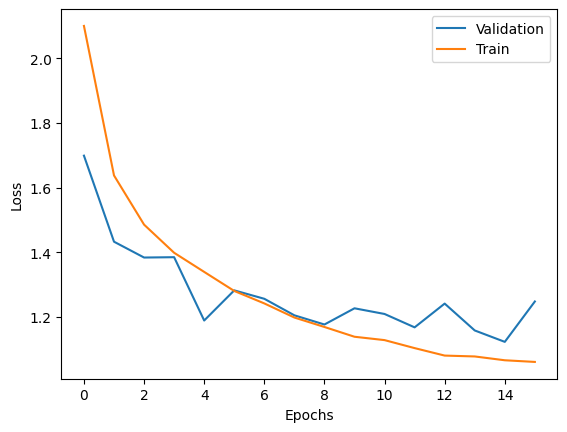

In [161]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

## 분류기 미세 튜닝하기

In [163]:
# model_ckpt = f'{model_ckpt}-issues-128' # 위 실행에서, 직전 결과를 huggingface에 업로드 하지 않았기에
model_ckpt = 'cj-mills/bert-base-uncased-issues-128' # 다른 사용자가 업로드한 결과 사용
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA는 도메인 적응을 의미합니다
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at cj-mills/bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cj-mill

{'loss': 0.6383, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.553311824798584, 'eval_micro f1': 0.016260162601626018, 'eval_macro f1': 0.013071895424836602, 'eval_runtime': 0.4052, 'eval_samples_per_second': 261.602, 'eval_steps_per_second': 9.872, 'epoch': 1.0}
{'loss': 0.5048, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4766559302806854, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4057, 'eval_samples_per_second': 261.277, 'eval_steps_per_second': 9.86, 'epoch': 2.0}
{'loss': 0.4275, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.4308495819568634, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4054, 'eval_samples_per_second': 261.47, 'eval_steps_per_second': 9.867, 'epoch': 3.0}
{'loss': 0.3843, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.402627557516098, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4042, 'eval_samples_per_second': 262.259, 'eval_steps_per_second': 9.897, 'epoch': 4.0}
{'loss': 0.351

Some weights of the model checkpoint at cj-mills/bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cj-mill

{'loss': 0.6161, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5120167136192322, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4044, 'eval_samples_per_second': 262.102, 'eval_steps_per_second': 9.891, 'epoch': 1.0}
{'loss': 0.4482, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4228927195072174, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4041, 'eval_samples_per_second': 262.294, 'eval_steps_per_second': 9.898, 'epoch': 2.0}
{'loss': 0.3745, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3863755464553833, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4044, 'eval_samples_per_second': 262.136, 'eval_steps_per_second': 9.892, 'epoch': 3.0}
{'loss': 0.3347, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.37077972292900085, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4059, 'eval_samples_per_second': 261.139, 'eval_steps_per_second': 9.854, 'epoch': 4.0}
{'loss': 0.3126, 'learning_rate': 3e-05, 'e

Some weights of the model checkpoint at cj-mills/bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cj-mill

{'loss': 0.5551, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.4350413978099823, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.404, 'eval_samples_per_second': 262.395, 'eval_steps_per_second': 9.902, 'epoch': 1.0}
{'loss': 0.3805, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.37504956126213074, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4038, 'eval_samples_per_second': 262.508, 'eval_steps_per_second': 9.906, 'epoch': 2.0}
{'loss': 0.3342, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3575623333454132, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4071, 'eval_samples_per_second': 260.369, 'eval_steps_per_second': 9.825, 'epoch': 3.0}
{'loss': 0.3028, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.344824880361557, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4063, 'eval_samples_per_second': 260.922, 'eval_steps_per_second': 9.846, 'epoch': 4.0}
{'loss': 0.2746, 'learning_rate': 3e-05, 'epo

Some weights of the model checkpoint at cj-mills/bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cj-mill

{'loss': 0.4882, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.37943336367607117, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4056, 'eval_samples_per_second': 261.352, 'eval_steps_per_second': 9.862, 'epoch': 1.0}
{'loss': 0.3555, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3508319556713104, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.406, 'eval_samples_per_second': 261.104, 'eval_steps_per_second': 9.853, 'epoch': 2.0}
{'loss': 0.3179, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3284788727760315, 'eval_micro f1': 0.19402985074626866, 'eval_macro f1': 0.07602339181286549, 'eval_runtime': 0.4071, 'eval_samples_per_second': 260.39, 'eval_steps_per_second': 9.826, 'epoch': 3.0}
{'loss': 0.2828, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.31317487359046936, 'eval_micro f1': 0.2589928057553957, 'eval_macro f1': 0.10204653770675638, 'eval_runtime': 0.4053, 'eval_samples_per_second': 261.533, 'eval_steps_per_second': 9.

Some weights of the model checkpoint at cj-mills/bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cj-mill

{'loss': 0.4215, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.35229942202568054, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.4054, 'eval_samples_per_second': 261.439, 'eval_steps_per_second': 9.866, 'epoch': 1.0}
{'loss': 0.3266, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.31579768657684326, 'eval_micro f1': 0.2589928057553957, 'eval_macro f1': 0.09302325581395349, 'eval_runtime': 0.4071, 'eval_samples_per_second': 260.369, 'eval_steps_per_second': 9.825, 'epoch': 2.0}
{'loss': 0.2798, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.28975579142570496, 'eval_micro f1': 0.32653061224489793, 'eval_macro f1': 0.11509891312846977, 'eval_runtime': 0.4075, 'eval_samples_per_second': 260.107, 'eval_steps_per_second': 9.815, 'epoch': 3.0}
{'loss': 0.2307, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.2451096624135971, 'eval_micro f1': 0.5301204819277109, 'eval_macro f1': 0.27398021132036476, 'eval_runtime': 0.4072, 'eval_samples_per_second': 26

Some weights of the model checkpoint at cj-mills/bert-base-uncased-issues-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cj-mill

{'loss': 0.3957, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.32777315378189087, 'eval_micro f1': 0.2463768115942029, 'eval_macro f1': 0.08994708994708994, 'eval_runtime': 0.4064, 'eval_samples_per_second': 260.849, 'eval_steps_per_second': 9.843, 'epoch': 1.0}
{'loss': 0.3009, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.2946951687335968, 'eval_micro f1': 0.2857142857142857, 'eval_macro f1': 0.11056376573617951, 'eval_runtime': 0.4086, 'eval_samples_per_second': 259.423, 'eval_steps_per_second': 9.79, 'epoch': 2.0}
{'loss': 0.2475, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.2329660803079605, 'eval_micro f1': 0.5325443786982249, 'eval_macro f1': 0.28967849226868647, 'eval_runtime': 0.4091, 'eval_samples_per_second': 259.132, 'eval_steps_per_second': 9.779, 'epoch': 3.0}
{'loss': 0.1831, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.20214346051216125, 'eval_micro f1': 0.6304347826086957, 'eval_macro f1': 0.44586706934971215, 'eval_runtime': 0.408, 'e

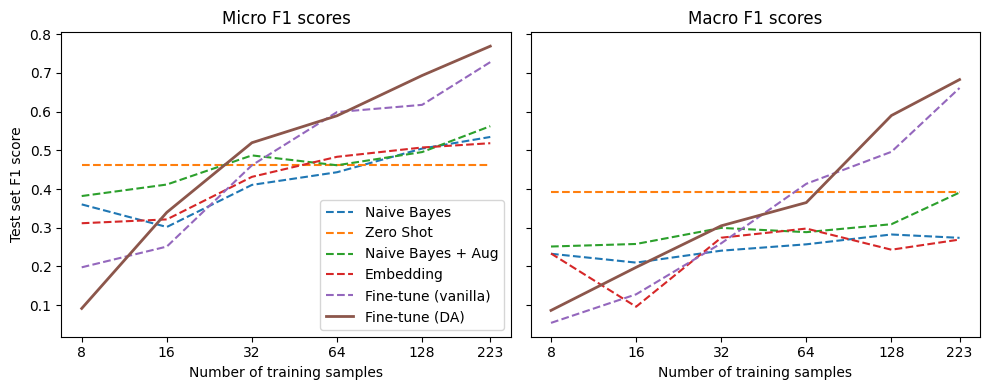

In [164]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

- 미세튜닝한 결과가, 레이블링된 데이터가 많을 수록 더 유리 하다.
- 도메인 적응이, 레이블링이 되지 않은 데이터와 약간의 노력으로 모델 성능을 조금 향상 시킬수 있다는 것을 의미

## 고급 방법
- 레이블링 되지 않은 데이터를 활용하는 고급 방법

#### 비지도 데이터 증식

- 비지도 데이터 증식(unsupervised data augmentation, UDA) : 레이블링 되지 않은 샘플과 살짝 왜곡된 샘플에 대해 모델의 예측이 일정해야 한다.
- 왜곡은 토큰 교체나 역 번역 같은 표준적인 데이터 증식 전략으로 만든다.
- 원본 예측과 왜곡된 샘플 예측 사이에 KL발산을 최소화 하도록 일관성을 강제로 부여(아래 그림 참조)

<img alt="uda" width="600" caption="Training a model M with UDA (courtesy of Qizhe Xie)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_uda.png?raw=1" id="uda"/>    

- 레이블링 되지 않은 샘플에 대한 크로스 엔트로피 손실을 보강, 일관성에 대한 요구사항을 통합
- 표준적 비지도학습으로 레이블링된 데이터에서 모델을 훈련 하지만, 레이블링되지 않은 데이터에서 일관된 예측을 만들도록 모델을 제한

- [추가 설명](https://velog.io/@riverdeer/paper-review-Unsupervised-Data-Augmentation-for-Consistency-Training#:~:text=Unsupervised%20Data%20Augmentation%20(UDA),-2.1.%20Background%3A%20Supervised&text=%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%A6%9D%EA%B0%95%EC%9D%80%20%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%98,%EB%A7%8C%EB%93%9C%EB%8A%94%20%EA%B2%83%EC%9D%84%20%EB%AA%A9%EC%A0%81%EC%9C%BC%EB%A1%9C%20%ED%95%9C%EB%8B%A4)
Unsupervised Data Augmentation (UDA)는 주어진 레이블된 데이터를 기반으로 하지 않고, 데이터의 양을 증가시키고 모델의 성능을 향상시키기 위해 사용되는 방법이다.

**목적**: UDA의 목적은 다음과 같다:
1. **데이터 양 증가**: 레이블이 없는 데이터를 사용하여 기존의 레이블된 데이터를 보완하여 모델에 더 많은 학습 데이터를 제공한다.
2. **모델 일반화 향상**: 데이터의 다양성을 증가시켜 모델의 일반화 성능을 향상시킨다.
3. **학습 데이터의 품질 향상**: 데이터 증강을 통해 생성된 데이터는 실제 데이터와 유사하지만 새로운 데이터이므로 모델의 학습을 보조하는 효과를 가진다.

**방법**: UDA는 다음과 같은 과정을 통해 이루어진다:
1. **데이터 변환**: 레이블이 없는 데이터에 변환을 적용하여 새로운 데이터를 생성한다. 이미지의 경우 회전, 확대 등의 변환을 적용하고, 텍스트의 경우 paraphrasing 등의 기술을 사용한다.
2. **모델 학습**: 생성된 데이터와 기존의 레이블된 데이터를 모두 사용하여 모델을 학습시킨다. 지도 학습에서는 레이블된 데이터의 정보를 활용하며, 비지도 학습에서는 생성된 데이터를 활용하여 모델을 학습시킨다.

**효과**: UDA는 다음과 같은 효과를 가져온다:
1. **성능 향상**: UDA를 통해 모델은 더 많은 데이터를 학습하고 다양한 데이터에 대해 더 강건하게 학습하게 되므로 일반적으로 성능이 향상된다.
2. **일반화 향상**: 다양한 데이터를 학습하므로 모델의 일반화 능력이 향상되어 새로운 데이터에 대한 예측 성능이 개선된다.
3. **데이터 효율성**: 레이블이 없는 데이터를 사용하여 모델을 학습하기 때문에 레이블이 많이 필요하지 않은 경우에도 효과적으로 모델을 학습할 수 있다.

요약하자면, UDA는 데이터의 다양성을 증가시켜 모델의 성능을 향상시키는 데 사용되는 방법으로, 새로운 데이터를 생성하고 이를 이용하여 모델을 학습함으로써 성능을 향상시킨다.

#### 불확실성 인지 자기 훈련

- 불확실성 인지 자기 훈련(uncertainty-aware self-training : UST): 레이블링 되지 않은 데이터를 활용하는 유망한 방법
- 레이블링된 데이터에서 티처 모델을 훈련하고
- 이 모델을 사용해 레이블링 되지 않은 데이터에서 의사 레이블을 만든다
- 스튜던트 모델은 의사 레이블 데이터에서 훈련 되고, 다음 반복에서는 티처가 된다

<img alt="ust" width="600" caption="The UST method consists of a teacher that generates pseudo-labels and a student that is subsequently trained on those labels; after the student is trained it becomes the teacher and the step is repeated (courtesy of Subhabrata Mukherjee)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter09_ust.png?raw=1" id="ust"/>

# 결론

- 레이블이 적거나 전혀 없는 데이터에서 모델을 구축하는 방법은 있다.
- 사전 훈련된 언어 모델(BERT, GPT-2 등)을 사용하거나 도메인 적응을 통해 성능을 향상시킬 수 있다.
- 적합한 방법은 데이터 양, 잡음 정도, 데이터의 사전 훈련된 말뭉치와의 유사성에 따라 다르며, 평가 파이프라인을 통해 확인할 수 있다.
- 트랜스포머의 유연한 API를 활용하여 여러 모델을 비교할 수 있다.
- 허깅페이스 허브에서 다양한 모델을 찾을 수 있고, 비슷한 문제를 해결한 선행 연구를 참고할 수 있다.
- 복잡한 방법(UAD, UST)과 데이터 수집의 트레이드 오프는 이 책의 범위를 벗어나나, 초기에 검증 세트와 테스트 세트를 만들어 접근법을 평가하는 것이 중요하다.
- 각 단계에서 레이블링된 데이터를 추가 수집할 수 있으며, 이를 위한 도구들이 있다.
- 목표에 맞게 고품질의 작은 데이터셋을 만드는 것이 합리적이며, 이를 위한 방법을 활용하여 레이블링된 데이터를 최대한 활용할 수 있다.